## Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
display(data.head())
display(data.describe())
display(data.info())
display(data.isnull().sum(axis = 0))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

<font>В датасете имеется признаки, которые влияют на целевой признак, цену, а так же признаки, при изменении которых цена наврали поменяется. Поэтому следует их удалить.</font><br> 
<font>Столбец "NumberOfPictures" попал в датасет, скорее всего из-за технического сбоя, так как его значения только 0.</font><br>
<font>Есть пропуски, которые нужно обработать. Перед построением моделей, необходимо проанализировать зависимость признаков и закодировать их.</font><br>

In [4]:
# заполнять пропуски усредненными соседних столбцов данными считаю некорректным, т.к. слишком большой размах по маркам,
# годам, и ценам на автомобили, поэтому пропуски заполним формальной заглушкой - "unknown" - данные неизвестны

data[['VehicleType','Gearbox','Model','FuelType','NotRepaired']] = data[['VehicleType','Gearbox','Model',
                                                                         'FuelType','NotRepaired']].fillna('unknown')

In [5]:
data.loc[(data['Price'] == 0)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,unknown,1990,unknown,0,corsa,150000,1,petrol,opel,unknown,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,unknown,2017,manual,0,golf,5000,12,petrol,volkswagen,unknown,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,unknown,0,unknown,5000,0,petrol,volkswagen,unknown,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,unknown,2000,manual,65,corsa,150000,0,unknown,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,unknown,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,unknown,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32


In [6]:
# отбросим строки с ценами менее 50 евро, наврятли за меньшую стоимость их можно купить

data = data.query('Price > 50')

In [7]:
# удалим неиформативные столбцы, так как они не являются признакоми, которые влияют на цену авто

data = data.drop(['DateCrawled','NumberOfPictures','PostalCode','DateCreated','LastSeen','RegistrationMonth'], axis=1)

In [8]:
data['RegistrationYear'].value_counts()

2000    22761
1999    21871
2005    21389
2006    19648
2001    19584
        ...  
1949        1
2222        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 139, dtype: int64

In [9]:
# отбросим строки с несуществующими годами в столбце "RegistrationYear"

data = data.query('1960 < RegistrationYear < 2022')

<AxesSubplot:>

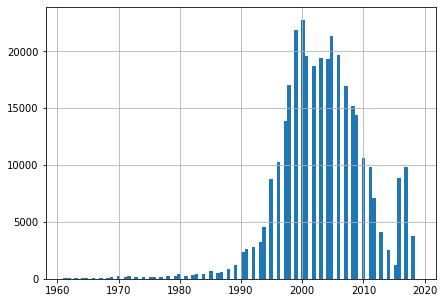

In [10]:
data['RegistrationYear'].hist(bins=100, figsize=(7,5))

In [11]:
data.loc[(data['Power'] == 0)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
32,245,sedan,1994,unknown,0,golf,150000,petrol,volkswagen,no
37,1500,unknown,2016,unknown,0,kangoo,150000,gasoline,renault,no
54,4700,wagon,2005,manual,0,signum,150000,unknown,opel,no
55,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354336,3299,unknown,2005,auto,0,outlander,150000,petrol,mitsubishi,unknown
354338,180,unknown,1995,unknown,0,unknown,125000,petrol,opel,unknown
354346,2600,unknown,2005,auto,0,c_klasse,150000,unknown,mercedes_benz,unknown
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no


In [12]:
# отбросим в столбце "Power", машин с менее 5 л.с. и более 1100 л.с., остальные данные аномальные

data = data.query('5 < Power < 1100')

In [13]:
display(data.head(10))
display(data.info())
display(data.describe())
display(data.isnull().sum(axis = 0))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,unknown,volkswagen,unknown
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 305605 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             305605 non-null  int64 
 1   VehicleType       305605 non-null  object
 2   RegistrationYear  305605 non-null  int64 
 3   Gearbox           305605 non-null  object
 4   Power             305605 non-null  int64 
 5   Model             305605 non-null  object
 6   Kilometer         305605 non-null  int64 
 7   FuelType          305605 non-null  object
 8   Brand             305605 non-null  object
 9   NotRepaired       305605 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.6+ MB


None

,Price,RegistrationYear,Power,Kilometer
count,305605.000000,305605.000000,305605.000000,305605.000000
mean,4823.875624,2003.343951,120.552468,128499.664600
std,4584.821569,6.810168,55.295200,36612.804387
min,55.000000,1961.000000,6.000000,5000.000000
25%,1350.000000,1999.000000,75.000000,125000.000000
50%,3150.000000,2003.000000,110.000000,150000.000000
75%,6950.000000,2008.000000,150.000000,150000.000000
max,20000.000000,2019.000000,1090.000000,150000.000000


Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

**Вывод** 

<font>На данном этапе был проделан первичный анализ и предобработка данных.</font><br> 
<font>Датасет изначально содержит 354369 строк и 16 столбцов с типами int и object. После обработки осталось строк 306989 и 10 столбцов.</font><br>
<font>Также имеются пропуски по некоторым столбцам, от которых избавились с помощью заглушки unknown.</font><br>
<font>Были удалены неинформативные столбцы и отсортированы нулевые значения по ценам, по мощности и несуществующие года.</font><br>

## Обучение моделей

In [14]:
# кодирование категориальных столбцов

encoder = OrdinalEncoder()
data_cod = pd.DataFrame(encoder.fit_transform(data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]),
                            columns=data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']].columns)

In [15]:
data_cod[['Price', 'RegistrationYear', 'Power', 'Kilometer']] = data[['Price', 'RegistrationYear', 'Power',
                                                                      'Kilometer']].reset_index(drop=True)
data_cod

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,Price,RegistrationYear,Power,Kilometer
0,2.0,1.0,227.0,2.0,1.0,2.0,18300,2011,190,125000
1,6.0,0.0,117.0,2.0,14.0,1.0,9800,2004,163,125000
2,5.0,1.0,116.0,6.0,38.0,0.0,1500,2001,75,150000
3,5.0,1.0,101.0,2.0,31.0,0.0,3600,2008,69,90000
4,4.0,1.0,11.0,6.0,2.0,2.0,650,1995,102,150000
...,...,...,...,...,...,...,...,...,...,...
305600,7.0,0.0,4.0,7.0,0.0,0.0,5250,2016,150,150000
305601,4.0,1.0,140.0,6.0,30.0,2.0,3200,2004,225,150000
305602,1.0,0.0,106.0,6.0,32.0,0.0,1199,2000,101,125000
305603,0.0,1.0,223.0,2.0,38.0,0.0,9200,1996,102,150000


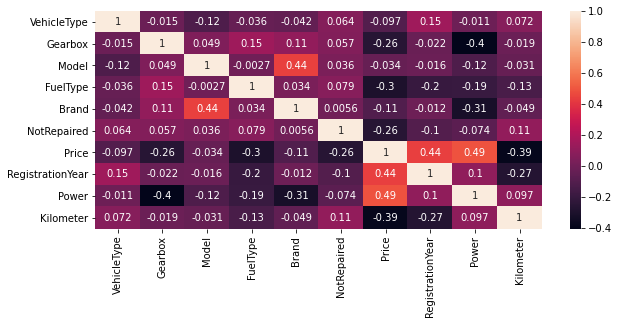

In [16]:
# построение корреляционной матрицы

plt.figure(figsize = (10,4))
corr_matrix = sns.heatmap(data_cod.corr(), annot=True)
plt.show()

In [17]:
# разобьем датасет на три выборки: обучающую, валидационною и тестовую

data_train, data_test = train_test_split(data_cod, test_size=0.25, random_state=12345)
data_train, data_valid = train_test_split(data_train, test_size=0.333, random_state=12345)

In [18]:
# сохраним признаки в переменные

features_train = data_train.drop(['Price'], axis=1)
target_train = data_train['Price']

features_test = data_test.drop(['Price'], axis=1)
target_test = data_test['Price']

features_valid = data_valid.drop(['Price'], axis=1)
target_valid = data_valid['Price']

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)
print(features_valid.shape)
print(target_valid.shape)

(152878, 9)
(152878,)
(76402, 9)
(76402,)
(76325, 9)
(76325,)


### Линейная регрессия

In [19]:
%%time

model_LR = LinearRegression()
model_LR.fit(features_train, target_train) 
predictions_valid_LR = model_LR.predict(features_valid)
mse_LR = mean_squared_error(target_valid, predictions_valid_LR)

print("RMSE:", mse_LR ** 0.5)

RMSE: 2951.7271076553884
CPU times: user 34.6 ms, sys: 21.6 ms, total: 56.2 ms
Wall time: 46.3 ms


### Градиентный бустинг с LightGBM

In [20]:
%%time

model_LGBM = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=12345)
model_LGBM.fit(features_train, target_train)

predictions_valid_LGBM = model_LGBM.predict(features_valid)

mse_LGBM = mean_squared_error(target_valid, predictions_valid_LGBM)

print("RMSE:", mse_LGBM ** 0.5)

RMSE: 1578.2657608279242
CPU times: user 3min 3s, sys: 923 ms, total: 3min 4s
Wall time: 3min 5s


### Градиентный бустинг с CatBoost

In [21]:
%%time

model_CBR = CatBoostRegressor(iterations=200, learning_rate=0.5, depth = 10)
model_CBR.fit(features_train, target_train, verbose=10) 
predictions_valid_CBR = model_CBR.predict(features_valid)
mse_CBR = mean_squared_error(target_valid, predictions_valid_CBR)

print("RMSE:", mse_CBR ** 0.5)

0:	learn: 3136.2433425	total: 102ms	remaining: 20.3s
10:	learn: 1795.8510503	total: 505ms	remaining: 8.67s
20:	learn: 1690.7722691	total: 864ms	remaining: 7.36s
30:	learn: 1629.8657579	total: 1.23s	remaining: 6.69s
40:	learn: 1574.9798398	total: 1.59s	remaining: 6.19s
50:	learn: 1541.1538923	total: 1.96s	remaining: 5.73s
60:	learn: 1515.3114084	total: 2.34s	remaining: 5.33s
70:	learn: 1489.3420028	total: 2.7s	remaining: 4.91s
80:	learn: 1467.6359050	total: 3.06s	remaining: 4.5s
90:	learn: 1448.7791217	total: 3.43s	remaining: 4.11s
100:	learn: 1433.8029877	total: 3.79s	remaining: 3.71s
110:	learn: 1415.6872075	total: 4.15s	remaining: 3.33s
120:	learn: 1402.8645713	total: 4.51s	remaining: 2.94s
130:	learn: 1391.4471489	total: 4.87s	remaining: 2.57s
140:	learn: 1379.7163244	total: 5.23s	remaining: 2.19s
150:	learn: 1368.0290926	total: 5.59s	remaining: 1.81s
160:	learn: 1357.6280585	total: 6.02s	remaining: 1.46s
170:	learn: 1346.6081183	total: 6.39s	remaining: 1.08s
180:	learn: 1336.369710

### Случайный лес

In [22]:
%%time

best_model_random_forest = None
best_result_random_forest = 0
for est in range(1, 60, 10):
    for depth in range(1, 15, 2):
        model_random_forest = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_random_forest.fit(features_train,target_train ) 
        result = model_random_forest.score(features_valid, target_valid)
        if result > best_result_random_forest:
            best_model_random_forest = model_random_forest
            best_result_random_forest =result 

print("Accuracy наилучшей модели случайный лес на валидационной выборке:", best_result_random_forest)
print("Лучшее гиперпараметры модели случайный лес на валидационной выборки:", best_model_random_forest)

Accuracy наилучшей модели случайный лес на валидационной выборке: 0.8595762832376851
Лучшее гиперпараметры модели случайный лес на валидационной выборки: RandomForestRegressor(max_depth=13, n_estimators=51, random_state=12345)
CPU times: user 2min 10s, sys: 193 ms, total: 2min 10s
Wall time: 2min 10s


In [23]:
model_random_forest = RandomForestRegressor(random_state=12345, n_estimators=51, max_depth=13)
model_random_forest.fit(features_train,target_train) 
predictions_valid_random_forest = model_random_forest.predict(features_valid)

mse_random_forest= mean_squared_error(target_valid, predictions_valid_random_forest)

print("RMSE:", mse_random_forest ** 0.5)

RMSE: 1707.7518177190511


**Вывод** 

<font>Все категориальные признаки закодировали с помощью OrdinalEncoder.</font><br>
<font>При построении корреляционной матрицы установили слабые зависимости между:
- ценой и километражем -0,38;
- ценой и типом топлива -0,3;
- брендом и моделью 0,44;
- ценой и годом выпуска 0,43.</font><br> 
<font>Данные разбили на три выборки обучающую, валидационную и тестовую.</font><br> 
Для обучения данных были выбраны модели: линейной регрессии, градиентный бустинг с LightGBM и CatBoost и случайный лес.

## Анализ моделей

In [24]:
%%time

predictions_valid_LGBM = model_LGBM.predict(features_test)

mse_LGBM = mean_squared_error(target_test, predictions_valid_LGBM)

print("RMSE:", mse_LGBM ** 0.5)

RMSE: 1581.4175045121356
CPU times: user 791 ms, sys: 9.99 ms, total: 801 ms
Wall time: 778 ms


In [25]:
%%time

predictions_valid_CBR = model_CBR.predict(features_test)
mse_CBR = mean_squared_error(target_test, predictions_valid_CBR)

print("RMSE:", mse_CBR ** 0.5)

RMSE: 1593.4517021997153
CPU times: user 59.7 ms, sys: 11 µs, total: 59.7 ms
Wall time: 102 ms


In [26]:
%%time

predictions_valid_random_forest = model_random_forest.predict(features_test)
mse_random_forest= mean_squared_error(target_test, predictions_valid_random_forest)

print("RMSE:", mse_random_forest ** 0.5)

RMSE: 1715.117199377744
CPU times: user 445 ms, sys: 72 µs, total: 446 ms
Wall time: 448 ms


In [27]:
# сводная таблица результатов

result = {'Линейная регрессия': pd.Series(['46.3 ms', '-', 2951.72, '-'],
                      index=['time for training', 'time to complete', 'RMSE on valid', 'RMSE on test']),
     'LGBM': pd.Series(['3min 5s', '778 ms', 1578.26, 1581.41],
                      index=['time for training', 'time to complete', 'RMSE on valid', 'RMSE on test']),
     'CatBoost': pd.Series(['8.19 s', '102 ms', 1593.58, 1593.45],
                      index=['time for training', 'time to complete', 'RMSE on valid', 'RMSE on test']),
     'Случайный лес': pd.Series(['2min 10s', '448 ms', 1707.75, 1715.11],
                      index=['time for training', 'time to complete', 'RMSE on valid', 'RMSE on test'])
                             }
 
pd.DataFrame(result)

,Линейная регрессия,LGBM,CatBoost,Случайный лес
time for training,46.3 ms,3min 5s,8.19 s,2min 10s
time to complete,-,778 ms,102 ms,448 ms
RMSE on valid,2951.72,1578.26,1593.58,1707.75
RMSE on test,-,1581.41,1593.45,1715.11


## Общий вывод

Для анализа данных по определению потенциально выгодной платформы и игры были проделаны следующие действия:

1. Подготовка данных
- удалены неинформативные столбцы: DateCrawled, NumberOfPictures, PostalCode, DateCreated, LastSeen, RegistrationMonth;
- пропуски заполнены значениями unknown;
- отброшены выбросы в RegistrationYear;
- удалены строки с ценой 0.

2. Обучение моделей
- корреляционный анализ не показал сильных зависимостей между признаками;
- данные разбиты на три выборки: train, valid и test;
- с худшим показателем RMSE - **Линейная регрессия: RMSE = 2951.72;**
- самой продолжительной моделью по времени обучения стала: **Градиентный бустинг с LightGBM: время обучения 3min 5s;**
- самой быстрой и качественной моделью стал - **Градиентный бустинг с CatBoost: время обучения 8.52 s и RMSE = 1619;**
- а деревянная модель показала длительное время, но хорошее качество - **Случайный лес: время обучения 2min 22s и RMSE = 1721.**

3. Анализ моделей

На тестовых данные проверим три модели подходящий заданный критерий, RMSE < 2500.

- **Градиентный бустинг с LightGBM: время обучения 778 ms и RMSE = 1581;**
- **Градиентный бустинг с CatBoost: время обучения 102 ms и RMSE = 1593;**
- **Случайный лес: время обучения 448 ms и RMSE = 1715;**

Лучшая модель по RMSE на валидационной (1578) и тестовой выборке (1581) это градиентный бустинг с помощью LightGBM, но по времени обучения модели лучная стала градиентный бустинг с CatBoost, при это имея тоже хорошие показатели RMSE, выше LGBM всего на 12 пунктов.